In [1]:
#importing the basics libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#loading our dataset
data=pd.read_csv('desktop/Bengaluru_House_Data.csv')

In [3]:
#take a look
data.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


In [4]:
data.shape

(13320, 9)

In [5]:
# take a look at that columns
data['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

In [6]:
# removing the misleading columns
data.drop(['availability','society','area_type'],axis=1, inplace=True)

In [7]:
#see the missing values
data.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

<Axes: >

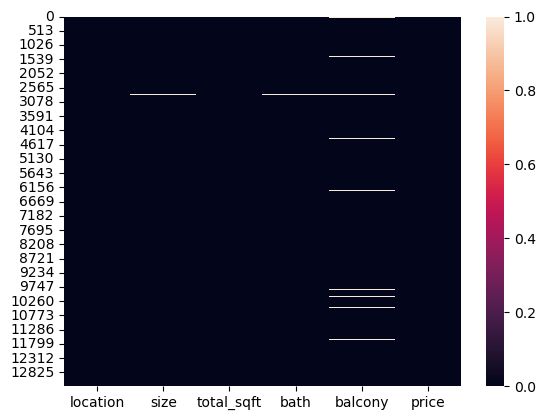

In [8]:
# see how it looks 
sns.heatmap(data.isnull())

In [9]:
#droping this because of its missing values .
data.drop(['balcony',],axis=1, inplace=True)

In [10]:
#clean the rest 
data.dropna(inplace=True)

In [11]:
data.head(5)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [12]:
# spliting the string part from the number and dropping the orginal column
data['num_of_rooms'] = data['size'].str.extract('(\d+)').astype(int)
data.drop('size',axis=1, inplace=True)

In [13]:
# Function to handle ranges in the 'total_sqft' column
def handle_range(value):
    if '-' in value:
        try:
            lower, upper = value.split('-')
            return (float(lower) + float(upper)) / 2
        except ValueError:
            return None  # Handle unexpected formats
    try:
        return float(value)
    except ValueError:
        return None  # Handle non-numeric values

# Apply the function to the 'total_sqft' column
data['total_sqft'] = data['total_sqft'].apply(handle_range)

# Convert to float if not already done
data['total_sqft'] = data['total_sqft'].astype(float)

# Handle missing values by filling with the median
median_value = data['total_sqft'].median()
data['total_sqft'].fillna(median_value, inplace=True)

# Display the first 5 rows
data.head(5)


,location,total_sqft,bath,price,num_of_rooms
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [14]:
#making a new column will help to get rid of the outliers and raise the score .
data['sqft_per_ft']=data['price']*10000/data['total_sqft']

# lets get rid of the outliers via these ...

In [15]:
from sklearn.covariance import EllipticEnvelope

def remove_outliers_elliptic_envelope(data, columns):
    envelope = EllipticEnvelope(contamination=0.05)  # Adjust contamination based on your dataset
    data['outlier'] = envelope.fit_predict(data[columns])
    return data[data['outlier'] != -1].drop('outlier', axis=1)

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data = remove_outliers_elliptic_envelope(data, numeric_columns)

In [16]:
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers_lof(data, columns, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    outliers = lof.fit_predict(data[columns])
    return data[outliers == 1]

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data = remove_outliers_lof(data, numeric_columns)


In [17]:
from scipy import stats

def remove_outliers_zscore(data, columns, threshold=3):
    z_scores = np.abs(stats.zscore(data[columns]))
    filtered_entries = (z_scores < threshold).all(axis=1)
    return data[filtered_entries]

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data = remove_outliers_zscore(data, numeric_columns)


In [18]:
#for sorting the index again >
data.reset_index(drop=True)

,location,total_sqft,bath,price,num_of_rooms,sqft_per_ft
0,Electronic City Phase II,1056.0,2.0,39.07,2,369.981061
1,Chikka Tirupathi,2600.0,5.0,120.00,4,461.538462
2,Uttarahalli,1440.0,2.0,62.00,3,430.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,624.589086
4,Kothanur,1200.0,2.0,51.00,2,425.000000
...,...,...,...,...,...,...
11430,Bellandur,1262.0,2.0,47.00,2,372.424723
11431,Uttarahalli,1345.0,2.0,57.00,3,423.791822
11432,Green Glen Layout,1715.0,3.0,112.00,3,653.061224
11433,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,525.854514


In [19]:
data.shape 

(11435, 6)

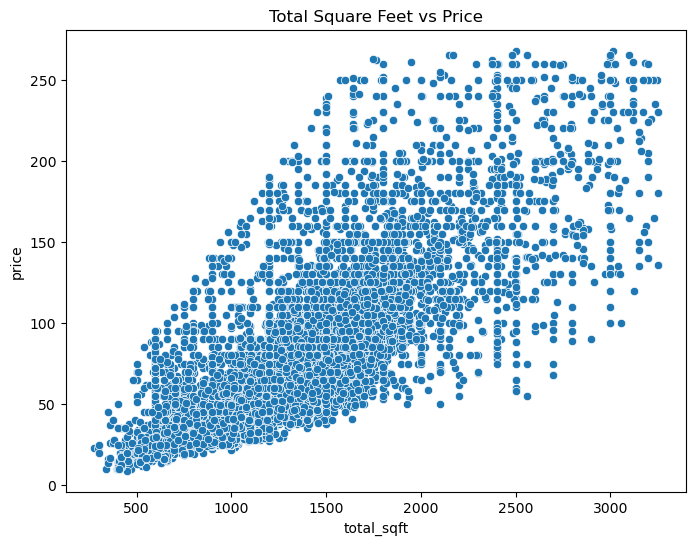

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_sqft', y='price', data=data)
plt.title('Total Square Feet vs Price')
plt.show()

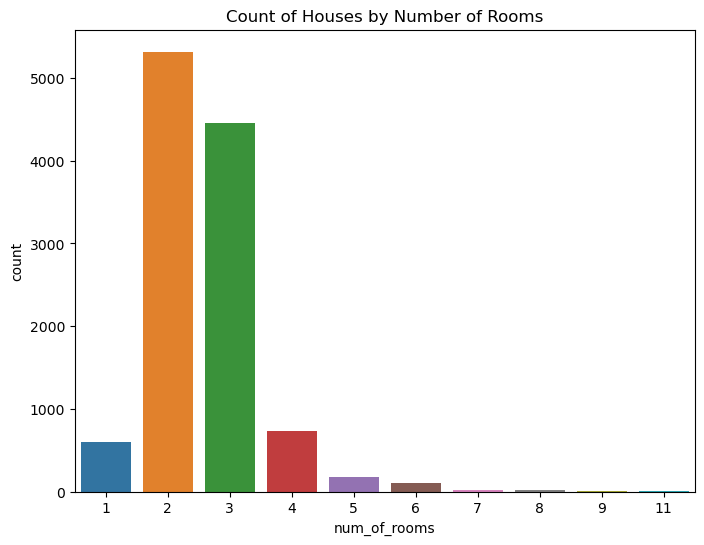

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num_of_rooms', data=data)
plt.title('Count of Houses by Number of Rooms')
plt.show()

C:\Users\96654\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


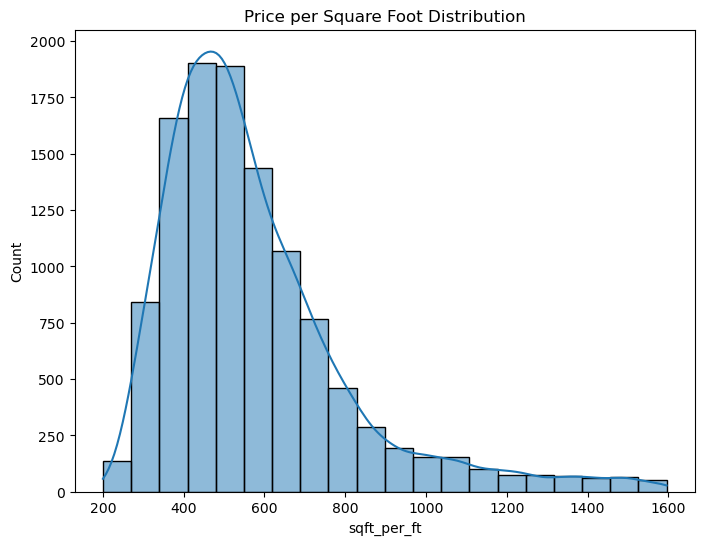

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data['sqft_per_ft'], bins=20, kde=True)
plt.title('Price per Square Foot Distribution')
plt.show()

In [23]:
# Select only numeric columns
numeric_df = data.select_dtypes(include='number')

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()
corr_matrix 

,total_sqft,bath,price,num_of_rooms,sqft_per_ft
total_sqft,1.000000,0.614180,0.740316,0.546640,0.139183
bath,0.614180,1.000000,0.617323,0.829536,0.390783
price,0.740316,0.617323,1.000000,0.545568,0.728015
num_of_rooms,0.546640,0.829536,0.545568,1.000000,0.375928
sqft_per_ft,0.139183,0.390783,0.728015,0.375928,1.000000


<Axes: >

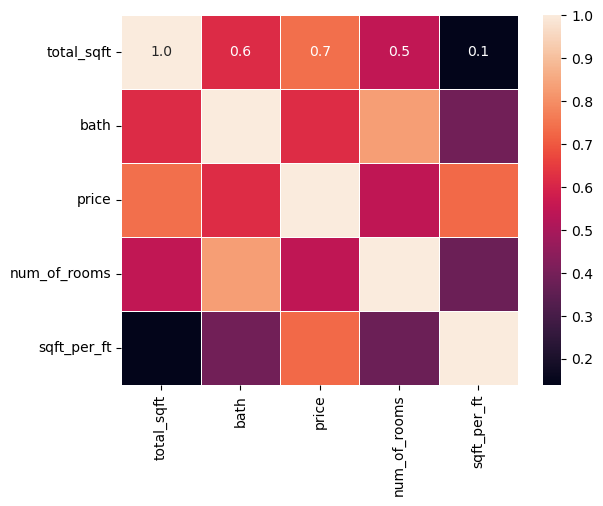

In [24]:
#seeing better reading 
sns.heatmap(corr_matrix,annot=True,fmt='.1f',linewidth=0.5)

In [25]:
#Calculate the count of each location in the data
location_stats = data['location'].value_counts()

# Group locations with less than or equal to 10 occurrences as 'Other'
location_stats_lessthan_10 = location_stats[location_stats <= 10]

# Apply the transformation to the 'location' column
data['location'] = data['location'].apply(lambda x: 'Other' if x in location_stats_lessthan_10 else x)

# Create dummy variables for the 'location' column and ensure they are in integer format (1 and 0)
dummies = pd.get_dummies(data['location'], prefix='location').astype(int)

# Concatenate the dummy variables to the original DataFrame, excluding the 'Other' column
data = pd.concat([data, dummies.drop('location_Other', axis=1)], axis=1)

# Drop the original 'location' column
data = data.drop('location', axis=1)

# Display the first 3 rows
data.head(3)

,total_sqft,bath,price,num_of_rooms,sqft_per_ft,location_ Devarachikkanahalli,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_5th Phase JP Nagar,location_6th Phase JP Nagar,...,location_Vasanthapura,location_Vidyaranyapura,location_Vijayanagar,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,1056.0,2.0,39.07,2,369.981061,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2600.0,5.0,120.00,4,461.538462,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1440.0,2.0,62.00,3,430.555556,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data.shape 

(11435, 211)

In [27]:
data.isnull().sum()

total_sqft                     0
bath                           0
price                          0
num_of_rooms                   0
sqft_per_ft                    0
                              ..
location_Yelachenahalli        0
location_Yelahanka             0
location_Yelahanka New Town    0
location_Yelenahalli           0
location_Yeshwanthpur          0
Length: 211, dtype: int64

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is your target column
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Mean Absolute Error (MAE): 5.8146
Mean Squared Error (MSE): 93.4622
R² Score: 0.9562


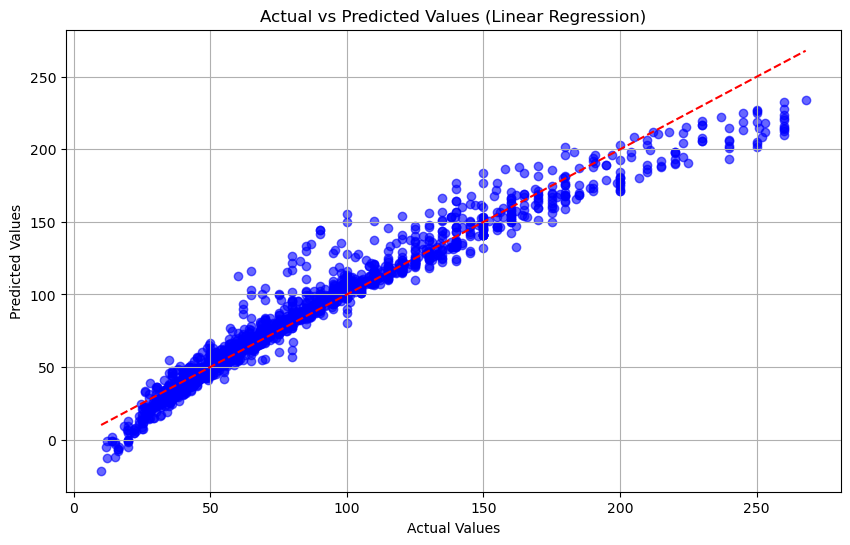

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.grid()
plt.show()

In [31]:
data.shape 

(11435, 211)

XGBoost Mean Absolute Error (MAE): 0.8039
XGBoost Mean Squared Error (MSE): 2.0890
XGBoost R² Score: 0.9990


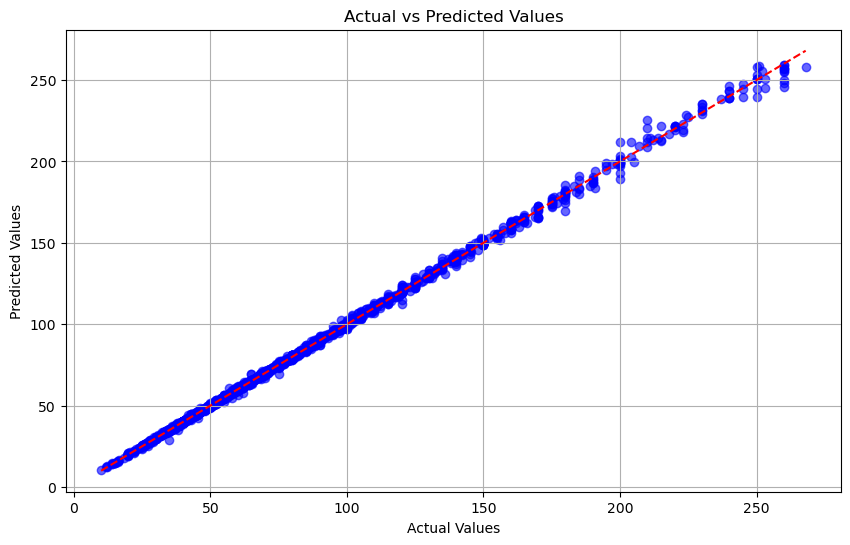

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print evaluation results
print(f"XGBoost Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"XGBoost Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")

# Plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid()
plt.show()

In [33]:
# Assuming y_test and y_pred are defined
# Create a DataFrame with actual and predicted prices
price_comparison_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred_xgb
})

# Optionally, reset the index for clarity
price_comparison_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
price_comparison_df.head(5)

,Actual Price,Predicted Price
0,140.0,136.725266
1,65.0,64.457703
2,85.0,83.817635
3,101.0,99.744904
4,110.0,111.153893


In [34]:
data.head(5)

,total_sqft,bath,price,num_of_rooms,sqft_per_ft,location_ Devarachikkanahalli,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_5th Phase JP Nagar,location_6th Phase JP Nagar,...,location_Vasanthapura,location_Vidyaranyapura,location_Vijayanagar,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,1056.0,2.0,39.07,2,369.981061,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2600.0,5.0,120.00,4,461.538462,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1440.0,2.0,62.00,3,430.555556,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1521.0,3.0,95.00,3,624.589086,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1200.0,2.0,51.00,2,425.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Assuming y_pred_xgb is the predictions from the test set
# Select the same indices from the original dataset that were used to generate predictions
test_indices = X_test.index  # or use the indices of your test set if you have them

# Create a DataFrame with the same length as y_pred_xgb
the_price = pd.DataFrame({
    'total_sqft': data.loc[test_indices, 'total_sqft'],
    'bath': data.loc[test_indices, 'bath'],
    'num_of_rooms': data.loc[test_indices, 'num_of_rooms'],
    'Predicted Price': y_pred_xgb
})

# Reset the index for clarity
the_price.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
the_price.head(4)


,total_sqft,bath,num_of_rooms,Predicted Price
0,900.00,4.0,5,136.725266
1,1419.59,2.0,3,64.457703
2,600.00,2.0,3,83.817635
3,1418.00,2.0,2,99.744904


In [36]:
the_price[the_price['total_sqft']==1255.00]

,total_sqft,bath,num_of_rooms,Predicted Price
19,1255.0,2.0,2,55.168781
217,1255.0,2.0,3,89.418861
253,1255.0,2.0,3,95.632072
312,1255.0,3.0,3,77.458946
358,1255.0,2.0,2,122.864433
762,1255.0,2.0,2,55.708534
921,1255.0,3.0,3,77.458946
966,1255.0,2.0,2,57.502308
1168,1255.0,2.0,2,50.085670
1482,1255.0,2.0,3,77.458946
